# OMOP Conversion Efficiency

## Import Libraries

In [1]:
import os
import pandas as pd

import psycopg2

from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm

## Connect to DB

In [2]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'mimiciv'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

## Read Data

In [4]:
mimicSelectedVitalsPath = os.getcwd() + '/../../data/mimic_selected_vitals.csv'
mimicSelectedVitalsDf = pd.read_csv(mimicSelectedVitalsPath)
mimicSelectedVitalsDf.head()

,Unnamed: 0,stay_id,heartrate,sysbp,diabp,meanbp,resprate,tempc,spo2,gcseye,gcsverbal,gcsmotor
0,0,30000153,106.840000,136.088235,67.794118,87.060606,14.166667,37.500000,96.640000,3.312500,3.187500,5.812500
1,1,30000213,81.680000,134.920000,56.160000,79.120000,19.595745,37.006944,98.960000,3.714286,3.571429,5.714286
2,2,30000484,89.958333,105.750000,55.625000,65.083333,14.708333,35.912698,99.791667,3.600000,1.000000,3.000000
3,3,30000646,86.423729,92.703704,56.481481,64.666667,25.627119,37.375000,95.610169,4.000000,5.000000,6.000000
4,4,30001148,75.520000,107.900000,58.400000,72.533333,13.875000,36.388889,98.360000,3.166667,3.666667,5.166667


In [5]:
mimicSelectedVitalsDf = mimicSelectedVitalsDf.iloc[: , 1:]
mimicSelectedVitalsDf.set_index('stay_id', inplace=True)
mimicSelectedVitalsDf.head()

,heartrate,sysbp,diabp,meanbp,resprate,tempc,spo2,gcseye,gcsverbal,gcsmotor
stay_id,,,,,,,,,,
30000153,106.840000,136.088235,67.794118,87.060606,14.166667,37.500000,96.640000,3.312500,3.187500,5.812500
30000213,81.680000,134.920000,56.160000,79.120000,19.595745,37.006944,98.960000,3.714286,3.571429,5.714286
30000484,89.958333,105.750000,55.625000,65.083333,14.708333,35.912698,99.791667,3.600000,1.000000,3.000000
30000646,86.423729,92.703704,56.481481,64.666667,25.627119,37.375000,95.610169,4.000000,5.000000,6.000000
30001148,75.520000,107.900000,58.400000,72.533333,13.875000,36.388889,98.360000,3.166667,3.666667,5.166667


In [6]:
mimicOmopSelectedVitalsPath = os.getcwd() + '/../../data/mimic_omop_selected_vitals.csv'
mimicOmopSelectedVitalsDf = pd.read_csv(mimicOmopSelectedVitalsPath)
mimicOmopSelectedVitalsDf.head()

,Unnamed: 0,visit_occurrence_id,heartrate,sysbp,diabp,meanbp,resprate,tempc,spo2,gcseye,gcsverbal,gcsmotor
0,0,-2147462198,100.764706,112.764706,77.411765,88.823529,19.941176,36.788889,97.470588,4.0,5.0,6.0
1,1,-2147363710,92.400000,106.640000,54.840000,70.120000,13.942857,36.886957,97.600000,2.5,3.0,3.5
2,2,-2147110420,67.761905,109.842105,41.578947,56.736842,17.916667,36.016667,99.950000,2.0,1.0,2.5
3,3,-2147080626,127.925926,116.291667,72.708333,82.375000,29.185185,37.222222,94.115385,4.0,5.0,6.0
4,4,-2147002424,101.370370,103.840000,57.200000,71.480000,22.851852,36.666667,148.333333,4.0,4.4,6.0


In [7]:
mimicOmopSelectedVitalsDf = mimicOmopSelectedVitalsDf.iloc[: , 1:]
mimicOmopSelectedVitalsDf.set_index('visit_occurrence_id', inplace=True)
mimicOmopSelectedVitalsDf.head()

,heartrate,sysbp,diabp,meanbp,resprate,tempc,spo2,gcseye,gcsverbal,gcsmotor
visit_occurrence_id,,,,,,,,,,
-2147462198,100.764706,112.764706,77.411765,88.823529,19.941176,36.788889,97.470588,4.0,5.0,6.0
-2147363710,92.400000,106.640000,54.840000,70.120000,13.942857,36.886957,97.600000,2.5,3.0,3.5
-2147110420,67.761905,109.842105,41.578947,56.736842,17.916667,36.016667,99.950000,2.0,1.0,2.5
-2147080626,127.925926,116.291667,72.708333,82.375000,29.185185,37.222222,94.115385,4.0,5.0,6.0
-2147002424,101.370370,103.840000,57.200000,71.480000,22.851852,36.666667,148.333333,4.0,4.4,6.0


## Compare Numbers

<BarContainer object of 2 artists>

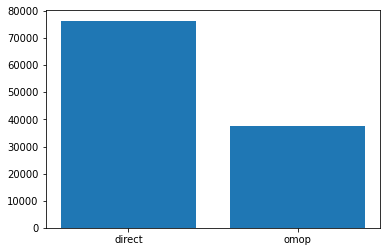

In [8]:
sources = ['direct', 'omop']
counts = []
counts.append(mimicSelectedVitalsDf.shape[0])
counts.append(mimicOmopSelectedVitalsDf.shape[0])

plt.bar(sources, counts)

## ID Uniquness

In [9]:
query = """
    SELECT
    COUNT(visit_occurrence_id)
    from omop_cdm.visit_occurrence
    """
df = pd.read_sql_query(query, con)
total_count = df['count'][0]

In [10]:
query = """
    SELECT
    COUNT(DISTINCT visit_occurrence_id)
    from omop_cdm.visit_occurrence
    """
df = pd.read_sql_query(query, con)
distinct_count = df['count'][0]

Text(1, 2434850, '2434850')

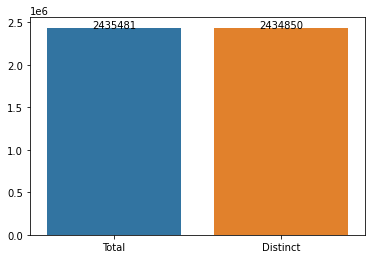

In [11]:
x = ['Total', 'Distinct']
y = [total_count, distinct_count]
g= sns.barplot(x=x, y=y)
g.text(0, y[0], y[0], color='black', ha="center")
g.text(1, y[1], y[1], color='black', ha="center")

## ID Overlaps

In [12]:
query = """
    SELECT
    visit_occurrence_id AS visit_occurrence_id,
    SUBSTR(trace_id, 12, 9) AS hadm_id
    FROM etl_dataset.cdm_visit_detail
    """
voHadmMappingDf = pd.read_sql_query(query, con)
voHadmMappingDf.head()

,visit_occurrence_id,hadm_id
0,962666805,27879859
1,962666805,27879859
2,-370548074,26420034
3,-370548074,26420034
4,-370548074,26420034


In [13]:
voHadmMappingDf.shape

(1667753, 2)

In [14]:
len(voHadmMappingDf.visit_occurrence_id.unique())

523706

In [15]:
len(voHadmMappingDf.hadm_id.unique())

523740

In [16]:
query = """
    SELECT
    hadm_id, stay_id
    FROM mimiciv.icustays
    """
stayidHadmMappingDf = pd.read_sql_query(query, con)
stayidHadmMappingDf.head()

,hadm_id,stay_id
0,24528534,31793211
1,28960964,31983544
2,27385897,33183475
3,23483021,34131444
4,20817525,34547665


In [17]:
stayidHadmMappingDf.shape

(76540, 2)

In [18]:
len(stayidHadmMappingDf.hadm_id.unique())

69211

In [19]:
len(stayidHadmMappingDf.stay_id.unique())

76540

In [20]:
voHadmMappingDf.hadm_id = pd.to_numeric(voHadmMappingDf.hadm_id, errors='coerce').fillna(0).astype('int64')

In [21]:
voHadmMappingDf.dtypes

visit_occurrence_id    int64
hadm_id                int64
dtype: object

In [22]:
stayidHadmMappingDf.dtypes

hadm_id    int64
stay_id    int64
dtype: object

In [23]:
idMappingDf = pd.merge(voHadmMappingDf, stayidHadmMappingDf, how="left", on=["hadm_id"])
idMappingDf

,visit_occurrence_id,hadm_id,stay_id
0,962666805,27879859,NaN
1,962666805,27879859,NaN
2,-370548074,26420034,NaN
3,-370548074,26420034,NaN
4,-370548074,26420034,NaN
...,...,...,...
1734706,-1853136701,29778759,NaN
1734707,-1213143560,24501336,NaN
1734708,-1213143560,24501336,NaN
1734709,-1213143560,24501336,NaN


In [24]:
idMappingDf.dtypes

visit_occurrence_id      int64
hadm_id                  int64
stay_id                float64
dtype: object

In [25]:
# idMappingDf.stay_id = idMappingDf.stay_id.astype(int64)
idMappingDf.stay_id = pd.to_numeric(idMappingDf.stay_id, errors='coerce').fillna(0).astype('int64')

In [26]:
idMappingDf.dtypes

visit_occurrence_id    int64
hadm_id                int64
stay_id                int64
dtype: object

In [27]:
idMappingDf[idMappingDf.stay_id.notna() & idMappingDf.stay_id != 0]

,visit_occurrence_id,hadm_id,stay_id
30,-943707553,26994982,31674811
31,-943707553,26994982,34324355
32,-943707553,26994982,31674811
33,-943707553,26994982,34324355
34,-943707553,26994982,31674811
...,...,...,...
1734637,2043881251,24692311,34477905
1734638,2043881251,24692311,34477905
1734690,994603994,20996594,35420979
1734691,994603994,20996594,35420979


In [28]:
idMappingDf.notna().sum()

visit_occurrence_id    1734711
hadm_id                1734711
stay_id                1734711
dtype: int64

In [29]:
len(idMappingDf.hadm_id.unique())

523740

In [30]:
len(idMappingDf.visit_occurrence_id.unique())

523706

In [31]:
len(idMappingDf.stay_id.unique())

76541

In [32]:
idMappingDf = idMappingDf.drop_duplicates()

In [33]:
idMappingDf.notna().sum()

visit_occurrence_id    531219
hadm_id                531219
stay_id                531219
dtype: int64

In [34]:
len(idMappingDf.hadm_id.unique()), len(idMappingDf.visit_occurrence_id.unique()), len(idMappingDf.stay_id.unique())

(523740, 523706, 76541)

In [35]:
len(set(mimicSelectedVitalsDf.index))

76448

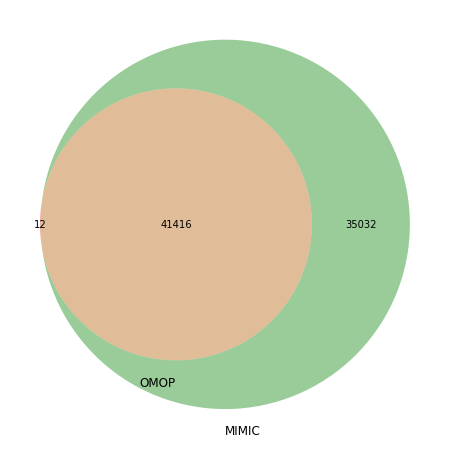

In [36]:
import numpy as np
from matplotlib_venn import venn2

plt.figure(figsize=(8, 8))

venn2(
    [
        set(idMappingDf[idMappingDf.visit_occurrence_id.isin(mimicOmopSelectedVitalsDf.index)].stay_id),
        set(mimicSelectedVitalsDf.index)
    ],
    set_labels = ('OMOP', 'MIMIC')
)

## Counts in different migration tables for vitals

In [39]:
rows = []
for itemid in ['220045', '220050', '220179', '220051', '220180', '220052', '220181', '225312', '220210', '224688', '224689', '224690', '223761', '223762', '220277', '220739', '223900', '223901']:

    counts = [itemid]

    query = """
    SELECT COUNT(*) FROM mimiciv.chartevents cev WHERE cev.itemid = """ + itemid + """
    """
    counts.append(pd.read_sql_query(query, con)['count'][0])

    query = """
    SELECT COUNT(*) FROM etl_dataset.lk_chartevents_clean src_cev_cln WHERE src_cev_cln.itemid = """ + itemid + """
    """
    counts.append(pd.read_sql_query(query, con)['count'][0])

    query = """
    SELECT COUNT(*) FROM etl_dataset.lk_chartevents_mapped src_cev_map WHERE src_cev_map.itemid = """ + itemid + """
    """
    counts.append(pd.read_sql_query(query, con)['count'][0])

    query = """
    SELECT COUNT(*) FROM etl_dataset.cdm_measurement cdm_mmt WHERE cdm_mmt.measurement_source_value = '""" + itemid + """'
    """
    counts.append(pd.read_sql_query(query, con)['count'][0])

    query = """
    SELECT COUNT(*) FROM omop_cdm.measurement mmt WHERE mmt.measurement_source_value = '""" + itemid + """'
    """
    counts.append(pd.read_sql_query(query, con)['count'][0])

    rows.append(counts)

In [40]:
pd.DataFrame(rows, columns = ['itemid', 'chartevents_count', 'chartevents_clean_count', 'chartevents_mapped_count', 'cdm_measurement_count', 'measurement_count'])

,itemid,chartevents_count,chartevents_clean_count,chartevents_mapped_count,cdm_measurement_count,measurement_count
0,220045,6798187,6798187,6798187,6798187,7486283
1,220050,2379566,2379566,2379566,2379566,2612690
2,220179,4279569,4279569,4279569,4279569,4719582
3,220051,2379199,2379199,2379199,2379199,2612247
4,220180,4278628,4278628,4278628,4278628,4718512
5,220052,2387853,2387853,2387853,2387853,2622569
6,220181,4276928,4276928,4276928,4276928,4716923
7,225312,242870,242870,242870,242870,259934
8,220210,6728530,6728530,6728530,6728530,7410589
9,224688,363651,363651,363651,363651,400769


## Counts in different migration tables for Admissions

In [3]:
query = """
select * from INFORMATION_SCHEMA.COLUMNS where table_name = 'admissions';
"""
pd.read_sql_query(query, con)

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,mimic4,mimiciv,admissions,subject_id,1,None,NO,integer,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,mimic4,mimiciv,admissions,hadm_id,2,None,NO,integer,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,mimic4,mimiciv,admissions,admittime,3,None,NO,timestamp without time zone,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,mimic4,mimiciv,admissions,dischtime,4,None,NO,timestamp without time zone,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
4,mimic4,mimiciv,admissions,deathtime,5,None,YES,timestamp without time zone,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
5,mimic4,mimiciv,admissions,admission_type,6,None,NO,character varying,50.0,200.0,...,NO,None,None,None,None,None,NO,NEVER,None,YES
6,mimic4,mimiciv,admissions,admission_location,7,None,YES,character varying,50.0,200.0,...,NO,None,None,None,None,None,NO,NEVER,None,YES
7,mimic4,mimiciv,admissions,discharge_location,8,None,YES,character varying,50.0,200.0,...,NO,None,None,None,None,None,NO,NEVER,None,YES
8,mimic4,mimiciv,admissions,insurance,9,None,NO,character varying,255.0,1020.0,...,NO,None,None,None,None,None,NO,NEVER,None,YES
9,mimic4,mimiciv,admissions,language,10,None,YES,character varying,10.0,40.0,...,NO,None,None,None,None,None,NO,NEVER,None,YES


In [4]:
query = """
select * from INFORMATION_SCHEMA.COLUMNS where table_name = 'visit_occurrence';
"""
pd.read_sql_query(query, con)

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,mimic4,omop_cdm,visit_occurrence,visit_occurrence_id,1,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,mimic4,omop_cdm,visit_occurrence,person_id,2,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,mimic4,omop_cdm,visit_occurrence,visit_concept_id,3,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,mimic4,omop_cdm,visit_occurrence,visit_start_date,4,None,YES,date,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
4,mimic4,omop_cdm,visit_occurrence,visit_start_datetime,5,None,YES,timestamp without time zone,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
5,mimic4,omop_cdm,visit_occurrence,visit_end_date,6,None,YES,date,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
6,mimic4,omop_cdm,visit_occurrence,visit_end_datetime,7,None,YES,timestamp without time zone,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
7,mimic4,omop_cdm,visit_occurrence,visit_type_concept_id,8,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
8,mimic4,omop_cdm,visit_occurrence,provider_id,9,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
9,mimic4,omop_cdm,visit_occurrence,care_site_id,10,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES


In [56]:
query = """
SELECT COUNT(*) FROM mimiciv.admissions
"""
print('Count in mimiciv.admissions Table: ' + str(pd.read_sql_query(query, con)['count'][0]))

Count in mimiciv.admissions Table: 523740


In [57]:
query = """
SELECT COUNT(*) FROM etl_dataset.src_admissions
"""
print('Count in etl_dataset.src_admissions Table: ' + str(pd.read_sql_query(query, con)['count'][0]))

Count in etl_dataset.src_admissions Table: 523740


In [58]:
query = """
SELECT COUNT(*) FROM etl_dataset.lk_admissions_clean
"""
print('Count in etl_dataset.lk_admissions_clean Table: ' + str(pd.read_sql_query(query, con)['count'][0]))

Count in etl_dataset.lk_admissions_clean Table: 523740


In [63]:
query = """
SELECT COUNT(*) FROM etl_dataset.lk_visit_no_hadm_dist
"""
print('Count in etl_dataset.lk_visit_no_hadm_dist Table: ' + str(pd.read_sql_query(query, con)['count'][0]))

Count in etl_dataset.lk_visit_no_hadm_dist Table: 1911741


In [59]:
query = """
SELECT COUNT(*) FROM etl_dataset.lk_visit_clean
"""
print('Count in etl_dataset.lk_visit_clean Table: ' + str(pd.read_sql_query(query, con)['count'][0]))

Count in etl_dataset.lk_visit_clean Table: 2435481


In [60]:
query = """
SELECT COUNT(*) FROM etl_dataset.cdm_visit_occurrence
"""
print('Count in etl_dataset.cdm_visit_occurrence Table: ' + str(pd.read_sql_query(query, con)['count'][0]))

Count in etl_dataset.cdm_visit_occurrence Table: 2435481


In [61]:
query = """
SELECT COUNT(*) FROM omop_cdm.visit_occurrence
"""
print('Count in omop_cdm.visit_occurrence Table: ' + str(pd.read_sql_query(query, con)['count'][0]))

Count in OMOP_CDM.visit_occurrence Table: 2435481


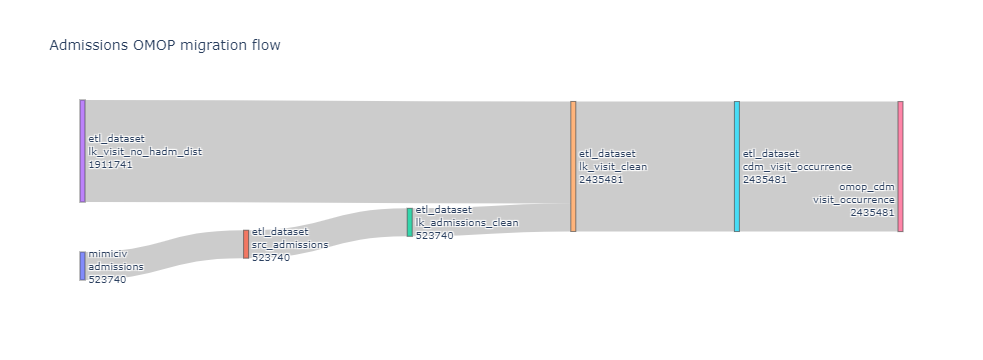

In [27]:
import plotly.graph_objects as go

# data
label = ["mimiciv<br>admissions<br>523740",
        "etl_dataset<br>src_admissions<br>523740",
        "etl_dataset<br>lk_admissions_clean<br>523740",
        "etl_dataset<br>lk_visit_no_hadm_dist<br>1911741",
        "etl_dataset<br>lk_visit_clean<br>2435481",
        "etl_dataset<br>cdm_visit_occurrence<br>2435481",
        "<br><br><br><br><br>omop_cdm<br>visit_occurrence<br>2435481"]
source = [0, 1, 2, 3, 4, 5]
target = [1, 2, 4, 4, 5, 6]
value = [523740, 523740, 523740, 1911741, 2435481, 2435481]
# data to dict, dict to sankey
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)
# plot
fig = go.Figure(data)
fig.update_layout(title_text="Admissions OMOP migration flow", font_size=10)
fig.show()

`visit_occurance table in OMOP contains all the entries from admissions table along with entries in labevents, specimen, organism, and antibiotics from the MIMIC dataset .`

## Counts in different migration tables for Patients

In [28]:
query = """
select * from INFORMATION_SCHEMA.COLUMNS where table_name = 'patients';
"""
pd.read_sql_query(query, con)

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,mimic4,mimiciv,patients,subject_id,1,None,NO,integer,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,mimic4,mimiciv,patients,gender,2,None,NO,character varying,5.0,20.0,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,mimic4,mimiciv,patients,anchor_age,3,None,NO,integer,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,mimic4,mimiciv,patients,anchor_year,4,None,NO,integer,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
4,mimic4,mimiciv,patients,anchor_year_group,5,None,NO,character varying,12.0,48.0,...,NO,None,None,None,None,None,NO,NEVER,None,YES
5,mimic4,mimiciv,patients,dod,6,None,YES,timestamp without time zone,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES


In [30]:
query = """
select * from INFORMATION_SCHEMA.COLUMNS where table_name = 'person';
"""
pd.read_sql_query(query, con)

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,mimic4,omop_cdm,person,person_id,1,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,mimic4,omop_cdm,person,gender_concept_id,2,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,mimic4,omop_cdm,person,year_of_birth,3,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,mimic4,omop_cdm,person,month_of_birth,4,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
4,mimic4,omop_cdm,person,day_of_birth,5,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
5,mimic4,omop_cdm,person,birth_datetime,6,None,YES,timestamp without time zone,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
6,mimic4,omop_cdm,person,race_concept_id,7,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
7,mimic4,omop_cdm,person,ethnicity_concept_id,8,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
8,mimic4,omop_cdm,person,location_id,9,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
9,mimic4,omop_cdm,person,provider_id,10,None,YES,integer,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES


In [31]:
query = """
SELECT COUNT(*) FROM mimiciv.patients
"""
print('Count in mimiciv.patients Table: ' + str(pd.read_sql_query(query, con)['count'][0]))

Count in mimiciv.patients Table: 382278


In [32]:
query = """
SELECT COUNT(*) FROM etl_dataset.src_patients
"""
print('Count in etl_dataset.src_patients Table: ' + str(pd.read_sql_query(query, con)['count'][0]))

Count in etl_dataset.src_patients Table: 382278


In [33]:
query = """
SELECT COUNT(*) FROM etl_dataset.cdm_person
"""
print('Count in etl_dataset.cdm_person Table: ' + str(pd.read_sql_query(query, con)['count'][0]))

Count in etl_dataset.cdm_person Table: 337942


In [34]:
query = """
SELECT COUNT(*) FROM omop_cdm.person
"""
print('Count in omop_cdm.person Table: ' + str(pd.read_sql_query(query, con)['count'][0]))

Count in omop_cdm.person Table: 337942


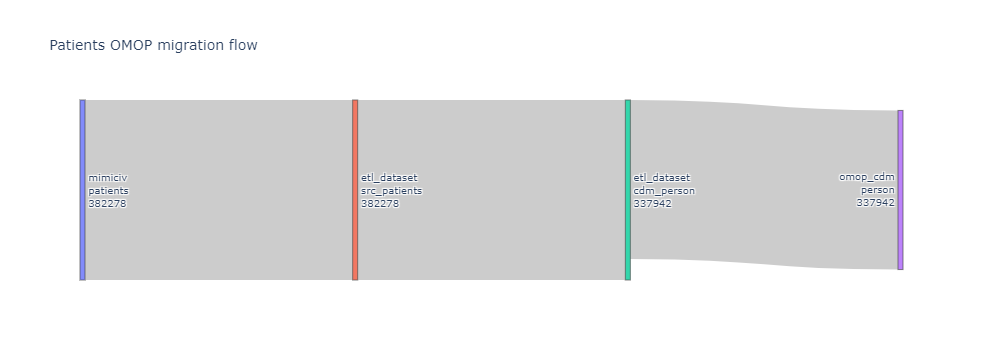

In [35]:
import plotly.graph_objects as go

# data
label = ["mimiciv<br>patients<br>382278",
        "etl_dataset<br>src_patients<br>382278",
        "etl_dataset<br>cdm_person<br>337942",
        "omop_cdm<br>person<br>337942"]
source = [0, 1, 2]
target = [1, 2, 3]
value = [382278, 382278, 337942, 337942]
# data to dict, dict to sankey
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)
# plot
fig = go.Figure(data)
fig.update_layout(title_text="Patients OMOP migration flow", font_size=10)
fig.show()

`Patients from cdm_person which have no records in cdm_observation_period is removed. Hence the drop in numbers.`

## Counts in different migration tables for lab values

In [68]:
rows = []
for itemid in tqdm(['50809', '50811', '50868', '50882', '50893', '50902', '50912', '50931', '50960', '50970', '50971', '50983', '51006', '51221', '51222', '51248', '51249', '51250', '51265', '51277', '51279', '51301', '51478', '51480', '51638', '51755', '51981', '52500', '52535', '52546', '52569', '52610', '52623', '52647']):

    counts = [itemid]

    query = """
    SELECT COUNT(*) FROM mimiciv.labevents lev WHERE lev.itemid = """ + itemid + """
    """
    counts.append(pd.read_sql_query(query, con)['count'][0])

    query = """
    SELECT COUNT(*) FROM etl_dataset.src_labevents src_lev WHERE src_lev.itemid = """ + itemid + """
    """
    counts.append(pd.read_sql_query(query, con)['count'][0])

    query = """
    SELECT COUNT(*) FROM etl_dataset.lk_meas_labevents_clean src_lev_cln WHERE src_lev_cln.itemid = """ + itemid + """
    """
    counts.append(pd.read_sql_query(query, con)['count'][0])

    query = """
    SELECT COUNT(*) FROM etl_dataset.lk_meas_labevents_mapped src_lev_map WHERE src_lev_map.itemid = """ + itemid + """
    """
    counts.append(pd.read_sql_query(query, con)['count'][0])

    query = """
    SELECT COUNT(*) FROM etl_dataset.cdm_measurement cdm_mmt WHERE cdm_mmt.measurement_source_value = '""" + itemid + """'
    """
    counts.append(pd.read_sql_query(query, con)['count'][0])

    query = """
    SELECT COUNT(*) FROM omop_cdm.measurement mmt WHERE mmt.measurement_source_value = '""" + itemid + """'
    """
    counts.append(pd.read_sql_query(query, con)['count'][0])

    rows.append(counts)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [14:37:03<00:00, 1547.74s/it]


In [69]:
pd.DataFrame(rows, columns = ['itemid', 'labevents_count', 'src_labevents_count', 'lk_meas_labevents_clean_count', 'lk_meas_labevents_mapped_count', 'cdm_measurement_count', 'measurement_count'])

,itemid,labevents_count,src_labevents_count,lk_meas_labevents_clean_count,lk_meas_labevents_mapped_count,cdm_measurement_count,measurement_count
0,50809,220300,220300,219081,219081,219049,204155
1,50811,116466,116466,116465,116465,116453,108999
2,50868,3077930,3077930,3077896,3077896,3077524,2844168
3,50882,3085714,3085714,3084894,3084894,3084522,2850771
4,50893,2247740,2247740,2247446,2247446,2247091,2078635
5,50902,3202975,3202975,3202472,3202472,3202100,2960349
6,50912,3378967,3378967,3377880,3377880,3377509,3122908
7,50931,2829673,2829673,2829301,2829301,2828930,2615978
8,50960,2206137,2206137,2205834,2205834,2205477,2042738
9,50970,2117240,2117240,2117004,2117004,2116650,1959528


## Compare Age Data (year)

In [6]:
mimicivQuery = """
SELECT anchor_year AS year FROM mimiciv.patients
"""
mimicivCounts = pd.read_sql_query(mimicivQuery, con)

In [7]:
omopQuery = """
SELECT year_of_birth AS year FROM omop_cdm.person
"""
omopCounts = pd.read_sql_query(omopQuery, con)

In [11]:
from scipy import stats

ttest, pval = stats.ttest_ind(mimicivCounts.year, omopCounts.year)

In [12]:
ttest, pval

(-2.5816567612357755, 0.00983292807939782)

In [13]:
from statsmodels.stats import weightstats as stests

ztest, pval1 = stests.ztest(x1=mimicivCounts.year, x2=omopCounts.year, value=0, alternative='two-sided')

In [14]:
ztest, pval1

(-2.5816567612357755, 0.009832732397823531)

<AxesSubplot:ylabel='year'>

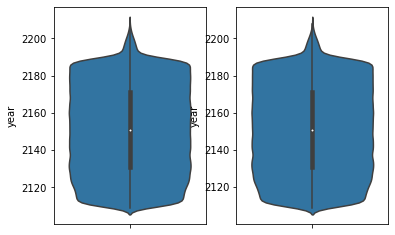

In [9]:
f, axes = plt.subplots(1, 2)
sns.violinplot(y="year", data=mimicivCounts, orient='v', ax=axes[0])
sns.violinplot(y="year", data=omopCounts, orient='v', ax=axes[1])

## Compare Gender Data

In [20]:
mimicivQuery = """
SELECT CASE WHEN gender = 'F' THEN 1 ELSE 0 END AS gender FROM mimiciv.patients
"""
mimicivDf = pd.read_sql_query(mimicivQuery, con)

In [21]:
omopQuery = """
SELECT CASE WHEN gender_source_value = 'F' THEN 1 ELSE 0 END AS gender FROM omop_cdm.person
"""
omopDf = pd.read_sql_query(omopQuery, con)

In [22]:
from scipy import stats

ttest, pval = stats.ttest_ind(mimicivDf.gender, omopDf.gender)

In [23]:
ttest, pval

(-9.308018540833949, 1.30586842515213e-20)

In [25]:
from statsmodels.stats import weightstats as stests

ztest, pval1 = stests.ztest(x1=mimicivDf.gender, x2=omopDf.gender, value=0, alternative='two-sided')

In [26]:
ztest, pval1

(-9.308018540833949, 1.3023926570250529e-20)

<AxesSubplot:ylabel='gender'>

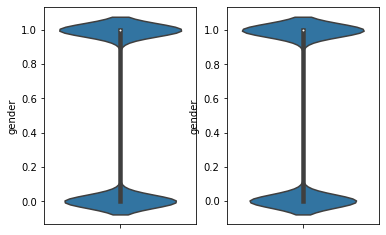

In [24]:
f, axes = plt.subplots(1, 2)
sns.violinplot(y="gender", data=mimicivDf, orient='v', ax=axes[0])
sns.violinplot(y="gender", data=omopDf, orient='v', ax=axes[1])

## Compare LOS Data

In [28]:
mimicivQuery = """
SELECT (dischtime::date - admittime::date) as los, dischtime, admittime FROM mimiciv.admissions
"""
mimicivDf = pd.read_sql_query(mimicivQuery, con)

In [29]:
omopQuery = """
SELECT (visit_end_date - visit_start_date) as los FROM omop_cdm.visit_occurrence
"""
omopDf = pd.read_sql_query(omopQuery, con)

In [30]:
from scipy import stats

ttest, pval = stats.ttest_ind(mimicivDf.los, omopDf.los)

In [31]:
ttest, pval

(474.7720505250659, 0.0)

In [32]:
from statsmodels.stats import weightstats as stests

ztest, pval1 = stests.ztest(x1=mimicivDf.los, x2=omopDf.los, value=0, alternative='two-sided')

In [33]:
ztest, pval1

(474.7720505250659, 0.0)

<AxesSubplot:ylabel='los'>

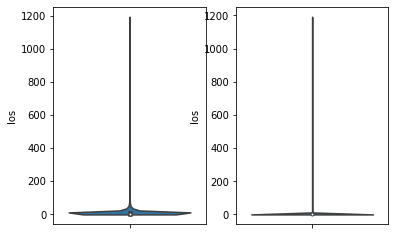

In [34]:
f, axes = plt.subplots(1, 2)
sns.violinplot(y="los", data=mimicivDf, orient='v', ax=axes[0])
sns.violinplot(y="los", data=omopDf, orient='v', ax=axes[1])

<AxesSubplot:ylabel='los'>

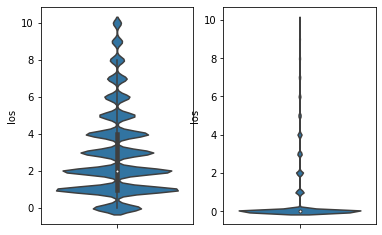

In [35]:
q1 = mimicivDf.los.quantile(0.25)
q3 = mimicivDf.los.quantile(0.75)
iqr = q3-q1 #Interquartile range
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr

f, axes = plt.subplots(1, 2)

sns.violinplot(y="los", data=mimicivDf[(mimicivDf.los>fence_low) & (mimicivDf.los<fence_high)], orient='v', ax=axes[0])
sns.violinplot(y="los", data=omopDf[(omopDf.los>fence_low) & (omopDf.los<fence_high)], orient='v', ax=axes[1])

## Compare Mortality Data

## Compare Distribution (Box Plots) - With outliers

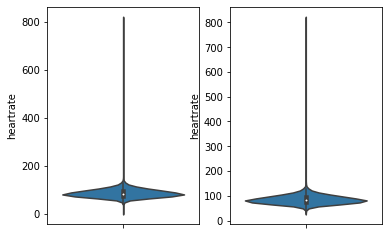

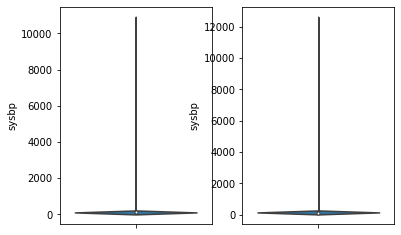

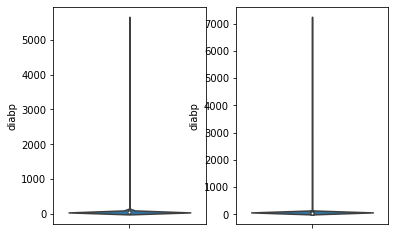

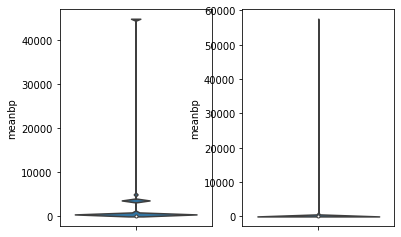

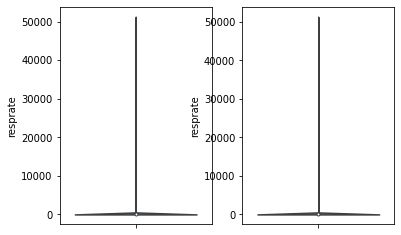

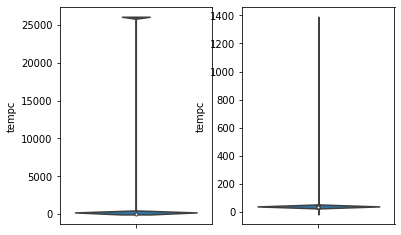

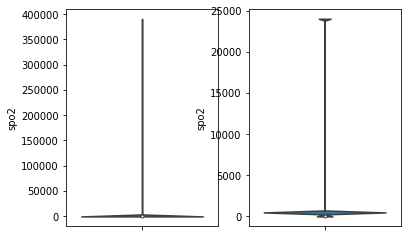

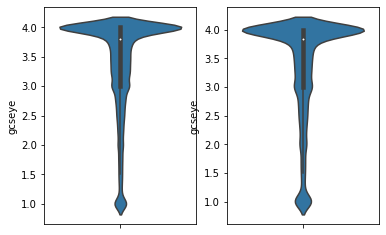

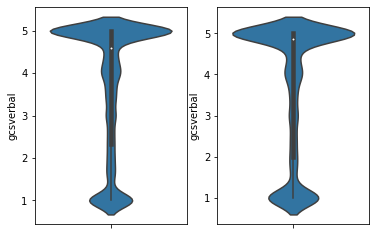

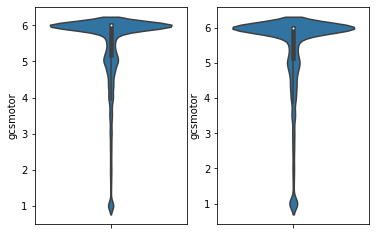

In [41]:
for col in mimicSelectedVitalsDf.columns:
    f, axes = plt.subplots(1, 2)
    sns.violinplot(y=col, data=mimicSelectedVitalsDf, orient='v', ax=axes[0])
    sns.violinplot(y=col, data=mimicOmopSelectedVitalsDf, orient='v', ax=axes[1])

## Compare Distribution (Box Plots) - Without outliers

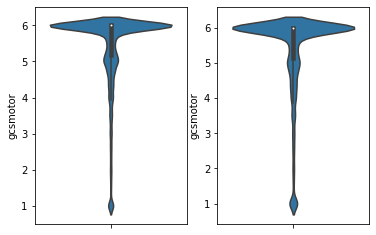

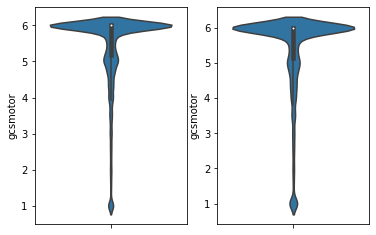

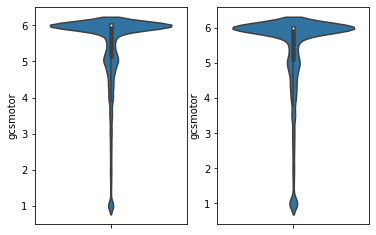

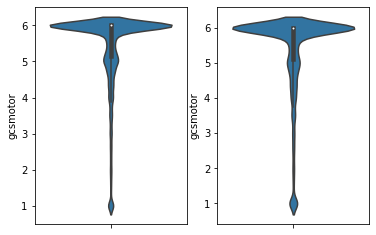

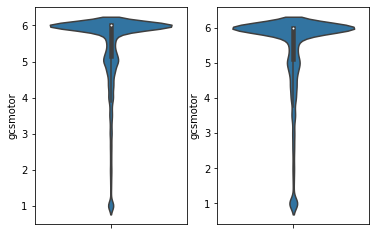

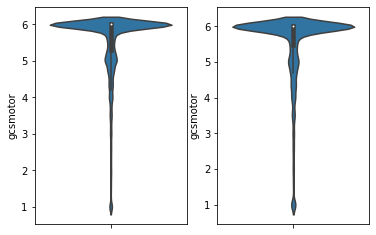

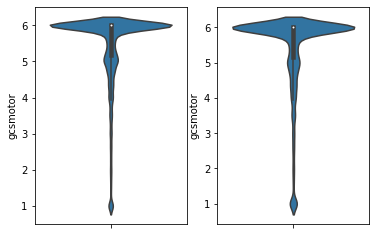

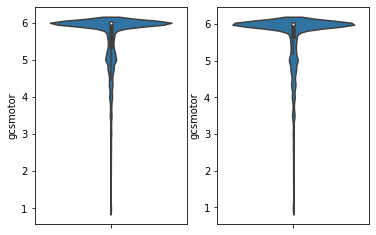

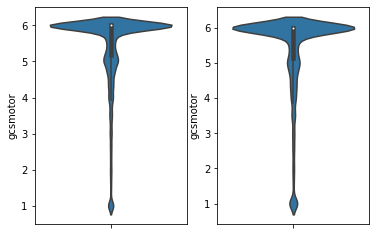

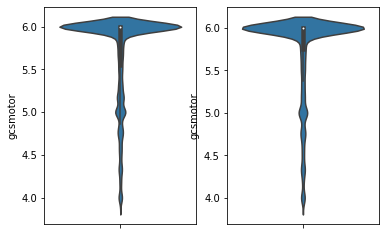

In [42]:
for dataColumn in mimicSelectedVitalsDf.columns:

    f, axes = plt.subplots(1, 2)

    q1 = mimicSelectedVitalsDf[dataColumn].quantile(0.25)
    q3 = mimicSelectedVitalsDf[dataColumn].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr

    sns.violinplot(y=col, data=mimicSelectedVitalsDf[(mimicSelectedVitalsDf[dataColumn]>fence_low) & (mimicSelectedVitalsDf[dataColumn]<fence_high)], orient='v', ax=axes[0])
    sns.violinplot(y=col, data=mimicOmopSelectedVitalsDf[(mimicOmopSelectedVitalsDf[dataColumn]>fence_low) & (mimicOmopSelectedVitalsDf[dataColumn]<fence_high)], orient='v', ax=axes[1])

## Compare Distribution (Density Plots) - With outliers

/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function 

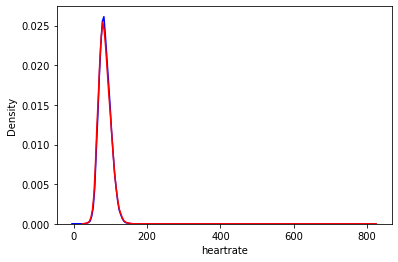

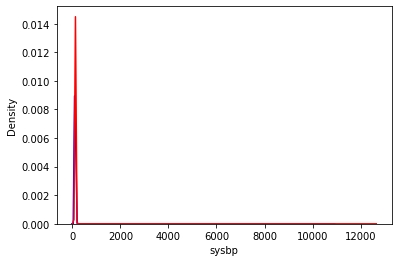

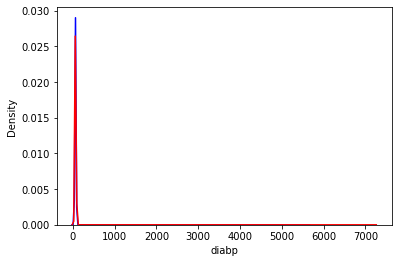

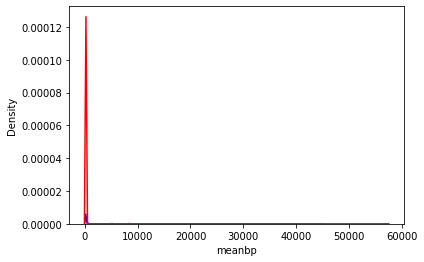

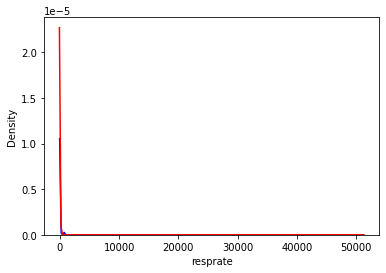

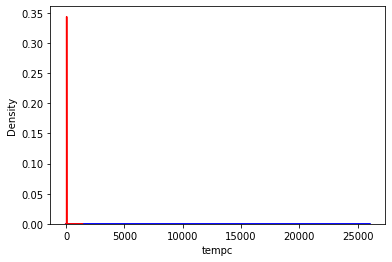

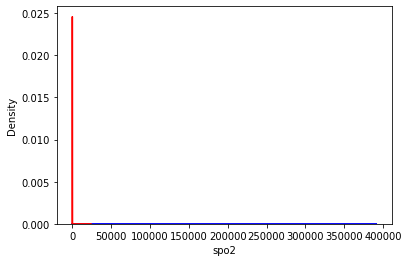

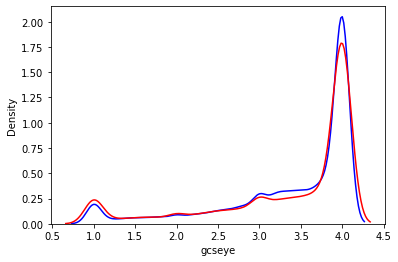

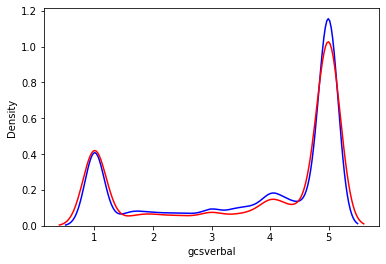

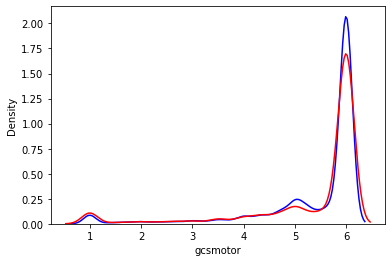

In [43]:
dataColumns = mimicSelectedVitalsDf.columns
for dataColumn in dataColumns:

    fig, ax = plt.subplots()

    sns.distplot(mimicSelectedVitalsDf[dataColumn], hist=False, color='blue', ax=ax)
    sns.distplot(mimicOmopSelectedVitalsDf[dataColumn], hist=False, color='red', ax=ax)

## Compare Distribution (Density Plots) - Without outliers

/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/superbugai-data/yash/chapter_1/workspace/EHRQC/notebooks/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function 

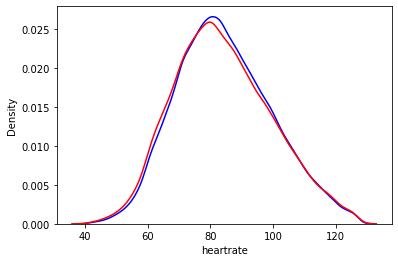

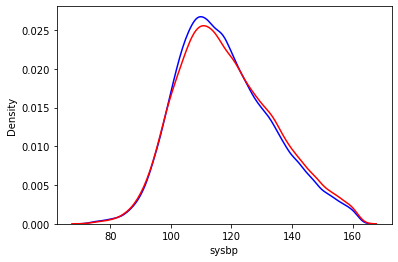

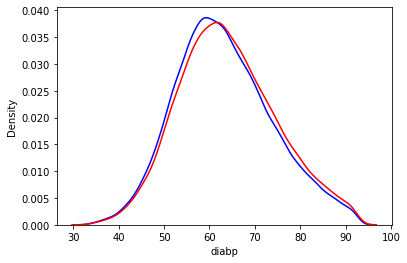

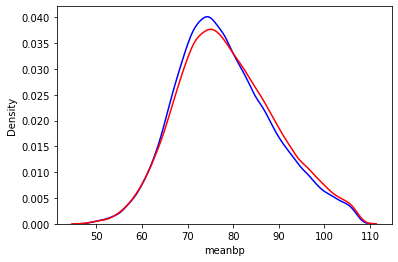

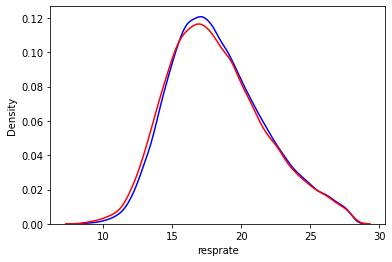

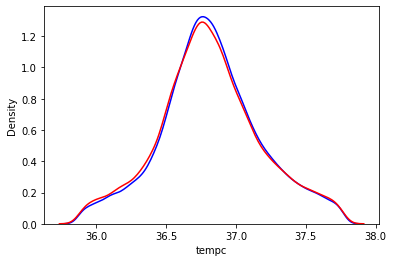

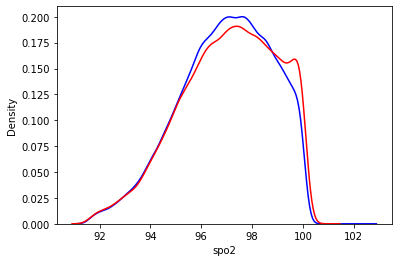

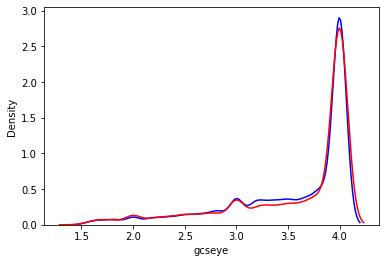

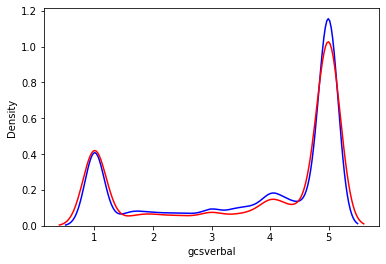

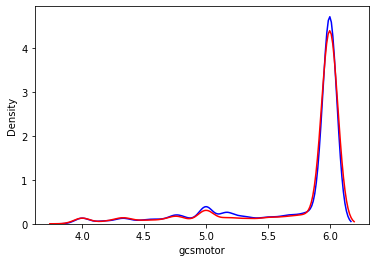

In [44]:
dataColumns = mimicSelectedVitalsDf.columns
for dataColumn in dataColumns:

    fig, ax = plt.subplots()

    q1 = mimicSelectedVitalsDf[dataColumn].quantile(0.25)
    q3 = mimicSelectedVitalsDf[dataColumn].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr

    sns.distplot(
        mimicSelectedVitalsDf[(mimicSelectedVitalsDf[dataColumn]>fence_low) & (mimicSelectedVitalsDf[dataColumn]<fence_high)][dataColumn],
        hist=False,
        color='blue',
        ax=ax
    )

    sns.distplot(
        mimicOmopSelectedVitalsDf[(mimicOmopSelectedVitalsDf[dataColumn]>fence_low) & (mimicOmopSelectedVitalsDf[dataColumn]<fence_high)][dataColumn],
        hist=False,
        color='red',
        ax=ax
    )
